#Importing library and checking for cuda

In [1]:
# !pip uninstall torch torchvision -y
# !pip install torch==2.3.0+cu121 torchvision==0.18.0+cu121 --extra-index-url https://download.pytorch.org/whl/cu121

In [2]:
# Dateset downloaded from https://www.kaggle.com/datasets/puneet6060/intel-image-classification

# PyTorch version: 2.3.0+cu121
# NumPy version: 1.25.2
# TorchVision version: 0.18.0+cu121

import os
import glob
import pathlib
import torch
import numpy as np
import torch.nn as nn
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt


# Checking for cuda
print(torch.cuda.is_available())

True


#Mounting Drive containing zip dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive/')
# %cd /content/drive/MyDrive/Image_Data_[Image_classificatin_cnn_pytorch]

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Unzipping data

In [4]:
# !unzip archive.zip
!unzip /content/drive/MyDrive/Image_Data_[Image_classificatin_cnn_pytorch]/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

setting paths to data

In [5]:
train_path = '/content/seg_train/seg_train'
pred_path = '/content/seg_pred/'
test_path = '/content/seg_test/seg_test'

#Model Building, Model Training, Model Testing and Saving


Using transformer to resize our images to 150x150

In [6]:
# Setting device to cuda if available
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
transformers = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(), # default probabilty 0.5 to flip an image horizontally inorder to increase the number of dataset
    transforms.ToTensor(), # this will change the color channel from 0-255 to 0-1, also convert numpy to tensor, as pytorch only works with tensor data
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
print(transformers)

Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [8]:
# Data loader to reduce the load on RAM for deeplearning
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transformers),
    batch_size=256,  # depends on memory capability of the cpu and gpu memory. Higher batch size can lead to data overload
    shuffle=True,
    num_workers=2
    )
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transformers),
    batch_size=256,
    shuffle=True,
    num_workers=2
    )

In [9]:
# Fetching all the classses
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Building CNN Network

In [10]:

class ConvNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ConvNet, self).__init__()
    # Input image shape (batch_size = 256, channels = 3(RGB), height = 150, width = 150)
    # Formula for calculating output = [(w-f+2p)/s] + 1; w = width, f = kernel size, p = padding, s = stride. Which will give the output as 150
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        # new shape = (256, 12, 150, 150)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        # new shape = (256, 12, 150, 150)
        self.relu1 = nn.ReLU()
        # new shape = (256, 12, 150, 150)

        self.maxpool = nn.MaxPool2d(kernel_size=2) # which will reduce the height and width of the output by a factor of 2
        # new shape = (256, 12, 75, 75)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        # new shape = (256, 20, 75, 75)
        self.relu2 = nn.ReLU()
        # new shape = (256, 20, 75, 75)


        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        # new shape = (256, 32, 75, 75)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        # new shape = (256, 32, 75, 75)
        self.relu3 = nn.ReLU()
        # new shape = (256, 32, 75, 75)


        self.fc = nn.Linear(in_features=32*75*75, out_features=num_classes)   # fully connected layers


        # feed forward function
    def forward(self, input):
        out = self.conv1(input)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)

        # Above matrix will be in matrix form with shape(256, 32, 75, 75)
        out = out.view(-1, 32*75*75)
        out = self.fc(out)

        return out



### Added more layers

In [11]:
# class ConvNet(nn.Module):
#     def __init__(self, num_classes=6):
#         super(ConvNet, self).__init__()

#         # Input image shape (batch_size = 256, channels = 3(RGB), height = 150, width = 150)
#         # Formula for calculating output = [(w-f+2p)/s] + 1; w = width, f = kernel size, p = padding, s = stride. Which will give the output as 150
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
#         # new shape = (256, 12, 150, 150)
#         self.bn1 = nn.BatchNorm2d(num_features=12)
#         # new shape = (256, 12, 150, 150)
#         self.relu1 = nn.ReLU()
#         # new shape = (256, 12, 150, 150)

#         self.maxpool = nn.MaxPool2d(kernel_size=2) # which will reduce the height and width of the output by a factor of 2
#         # new shape = (256, 12, 75, 75)

#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
#         # new shape = (256, 20, 75, 75)
#         self.relu2 = nn.ReLU()
#         # new shape = (256, 20, 75, 75)

#         self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
#         # new shape = (256, 32, 75, 75)
#         self.bn3 = nn.BatchNorm2d(num_features=32)
#         # new shape = (256, 32, 75, 75)
#         self.relu3 = nn.ReLU()
#         # new shape = (256, 32, 75, 75)

#         # New layers...
#         self.conv4 = nn.Conv2d(in_channels=32, out_channels=40, kernel_size=3, stride=1, padding=1)
#         # new shape = (256, 40, 75, 75)
#         self.relu4 = nn.ReLU()
#         # new shape = (256, 40, 75, 75)

#         self.conv5 = nn.Conv2d(in_channels=40, out_channels=48, kernel_size=3, stride=1, padding=1)
#         # new shape = (256, 48, 75, 75)
#         self.bn5 = nn.BatchNorm2d(num_features=48)
#         # new shape = (256, 48, 75, 75)
#         self.relu5 = nn.ReLU()
#         # new shape = (256, 48, 75, 75)

#         self.maxpool2 = nn.MaxPool2d(kernel_size=2) # which will reduce the height and width of the output by a factor of 2
#         # new shape = (256, 48, 37, 37)

#         # Add dropout layer to prevent overfitting
#         self.dropout = nn.Dropout(p=0.5)

#         self.fc1 = nn.Linear(in_features=48*37*37, out_features=128)  # fully connected layer
#         # new shape = (256, 128)
#         self.relu_fc1 = nn.ReLU()
#         # new shape = (256, 128)

#         self.fc2 = nn.Linear(in_features=128, out_features=num_classes)  # fully connected layer
#         # new shape = (256, num_classes)

#     def forward(self, input):
#         out = self.conv1(input)
#         out = self.bn1(out)
#         out = self.relu1(out)

#         out = self.maxpool(out)

#         out = self.conv2(out)
#         out = self.relu2(out)

#         out = self.conv3(out)
#         out = self.bn3(out)
#         out = self.relu3(out)

#         out = self.conv4(out)
#         out = self.relu4(out)

#         out = self.conv5(out)
#         out = self.bn5(out)
#         out = self.relu5(out)

#         out = self.maxpool2(out)

#         out = out.view(-1, 48*37*37)
#         out = self.dropout(out)  # Apply dropout
#         out = self.fc1(out)
#         out = self.relu_fc1(out)

#         out = self.fc2(out)

#         return out

In [12]:
model = ConvNet(num_classes = 6).to(device)

In [13]:
# Optimize and loss function
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0005)  # Increased weight decay for regularization
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

In [14]:
epocs = 100

In [15]:
# Calculating the size of training and testing images
train_count = len(glob.glob(train_path + '/**/*.jpg'))
test_count = len(glob.glob(test_path + '/**/*.jpg'))
print('Test_count =', test_count)
print('Train_count =', train_count)


Test_count = 3000
Train_count = 14034


### Training and Evaluating

In [16]:
_trainloss = []
_trainacc = []
_testacc = []
_testloss = []

In [17]:
# Model Training and saving best model
best_accuracy = 0.0

for epoch in range(epocs):
  # Evaluation on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        optimizer.zero_grad()

        outputs = model(images)    # This will give us the prediction
        loss = loss_function(outputs, labels) # This will give us the loss/ error using the predicted and the actual value
        loss.backward()   # will do the backpropagation
        optimizer.step()   # will update the weights and bias

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy /= train_count
    train_loss /= train_count

    # Evaluation of testing dataset
    model.eval()
    test_accuracy = 0.0
    test_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_loss += loss.cpu().data * images.size(0)
            prediction = torch.max(outputs.data, 1)[1]
            test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy /= test_count
    test_loss /= test_count
    scheduler.step()

    print('Epoch:{}\n   Train Loss: {}\n   Train Accuracy: {}\n   Test Loss: {}\n   Test Accuracy: {}'.format(epoch, train_loss, train_accuracy, test_loss, test_accuracy))
    _trainloss.append(train_loss)
    _trainacc.append(train_accuracy)
    _testacc.append(test_accuracy)
    _testloss.append(test_loss)
    # Save the model
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = test_accuracy


Epoch:0
   Train Loss: 8.74493408203125
   Train Accuracy: 0.5519452757588713
   Test Loss: 1.7158039808273315
   Test Accuracy: 0.6286666666666667
Epoch:1
   Train Loss: 1.1775659322738647
   Train Accuracy: 0.7441214194100043
   Test Loss: 1.335315465927124
   Test Accuracy: 0.714
Epoch:2
   Train Loss: 1.0699225664138794
   Train Accuracy: 0.7783240701154339
   Test Loss: 2.1353983879089355
   Test Accuracy: 0.6473333333333333
Epoch:3
   Train Loss: 0.6584912538528442
   Train Accuracy: 0.8502208921191392
   Test Loss: 2.2283732891082764
   Test Accuracy: 0.655
Epoch:4
   Train Loss: 0.4087410569190979
   Train Accuracy: 0.8943993159469859
   Test Loss: 1.5030485391616821
   Test Accuracy: 0.7323333333333333
Epoch:5
   Train Loss: 0.52290940284729
   Train Accuracy: 0.8824996437223885
   Test Loss: 1.7037498950958252
   Test Accuracy: 0.7263333333333334
Epoch:6
   Train Loss: 0.340379536151886
   Train Accuracy: 0.9164885278609092
   Test Loss: 1.5940383672714233
   Test Accuracy: 0

In [18]:
print(len(_trainloss))
print(len(_trainacc))
print(len(_testacc))
print(len(_testloss))

100
100
100
100


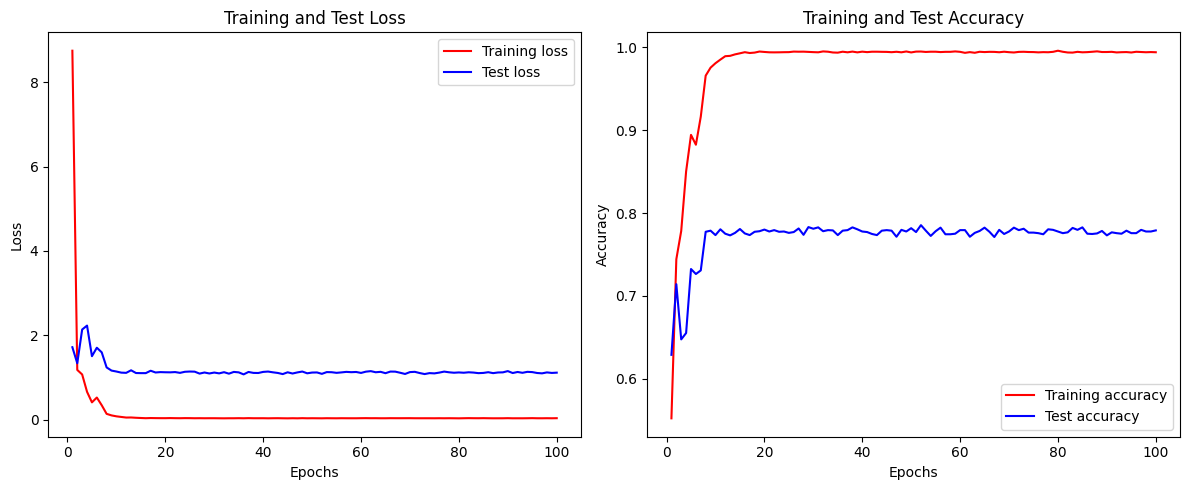

In [19]:
epochs = range(1, epocs + 1)

# Plot training and test loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, _trainloss, 'r', label='Training loss')
plt.plot(epochs, _testloss, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, _trainacc, 'r', label='Training accuracy')
plt.plot(epochs, _testacc, 'b', label='Test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#Predicting

In [20]:
model = ConvNet(num_classes = 6).to(device)
model.load_state_dict(torch.load('best_checkpoint.model'))

<ipython-input-20-eaf8d857ff1c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_checkpoint.model'))


<All keys matched successfully>

In [21]:
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

In [22]:
pred_path = '/content/seg_pred/'
transformers = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [23]:
pred_loader = DataLoader(
    torchvision.datasets.ImageFolder(pred_path, transformers),
    batch_size=256,
    shuffle=False,
    num_workers=2
)

In [24]:
# Evaluation
pred_accuracy = 0.0
pred_count = len(pred_loader.dataset)
print('Pred_count =', pred_count)

Pred_count = 7301


In [25]:
for i, (images, labels) in enumerate(pred_loader):
  if torch.cuda.is_available():
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
  outputs = model(images)
  _ ,prediction = torch.max(outputs.data, 1)
  pred_accuracy += int(torch.sum(prediction == labels.data))

pred_accuracy = pred_accuracy / pred_count
print('Pred Accuracy: {}%'.format(pred_accuracy*100))

Pred Accuracy: 14.504862347623613%


# Displaying images from the Pred Folder

In [26]:
import matplotlib.pyplot as plt

def show_image(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [27]:
data_iter = iter(pred_loader)
images, labels = next(data_iter)
print(images.shape)
print(labels.shape)

torch.Size([256, 3, 150, 150])
torch.Size([256])


In [28]:
# Giving names to each predicted labels
class_names = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

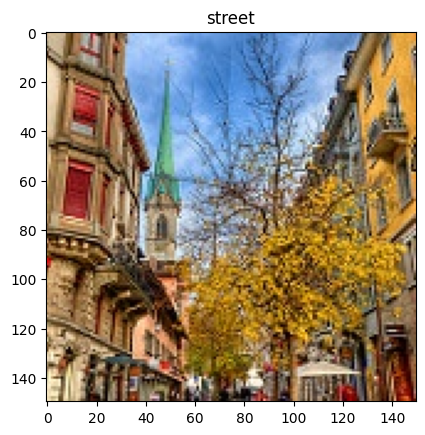

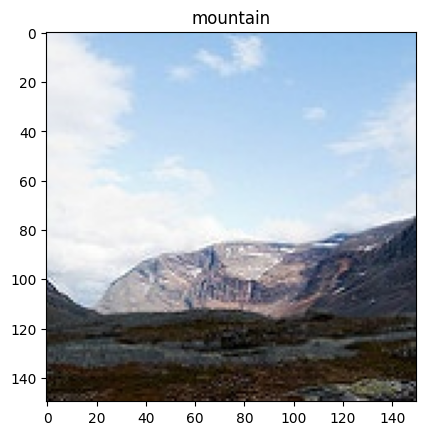

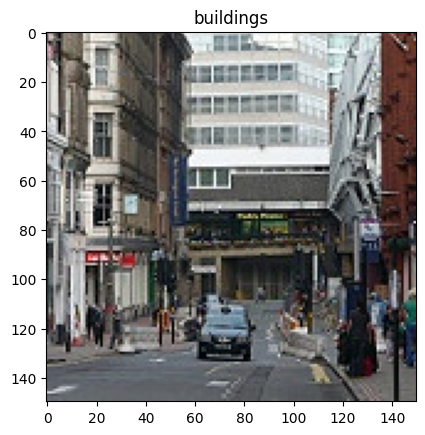

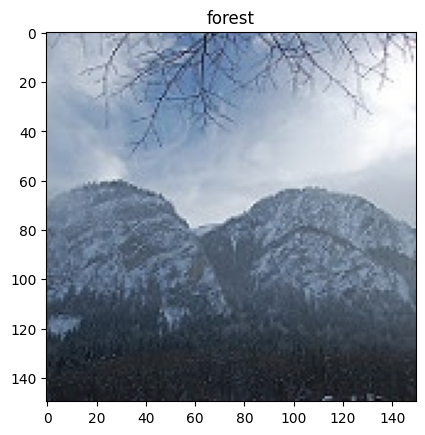

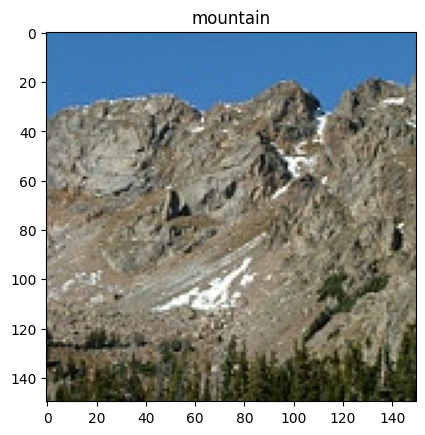

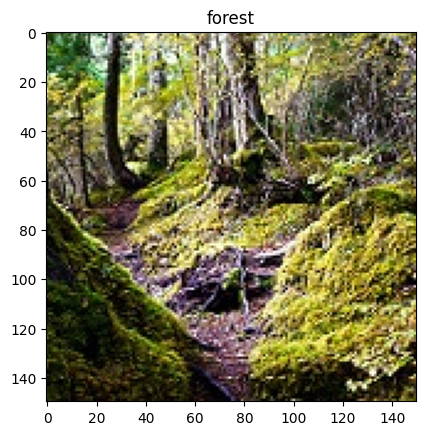

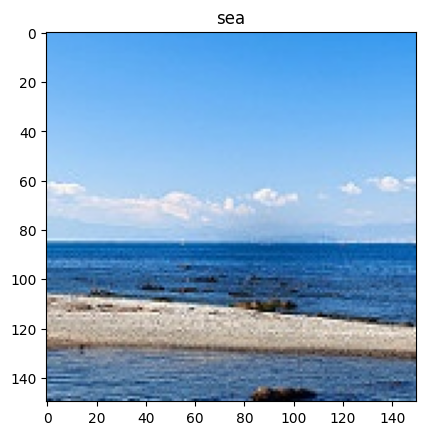

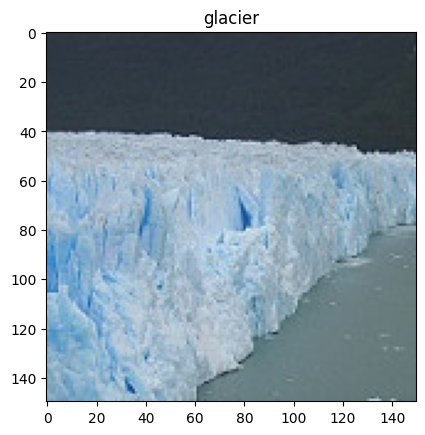

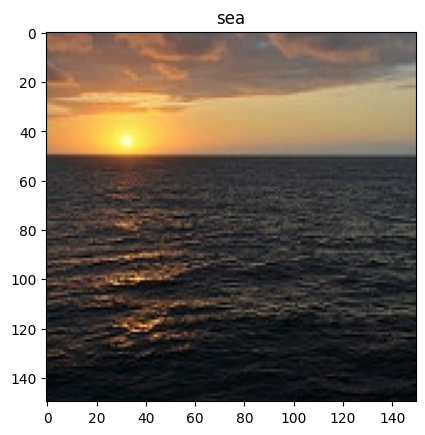

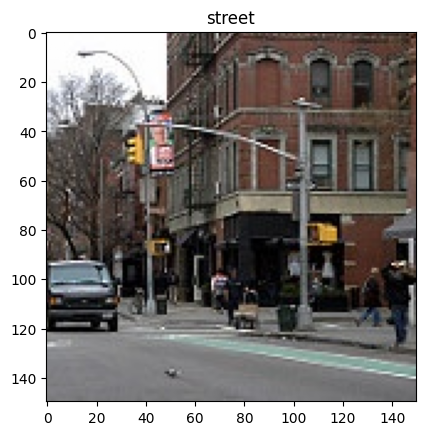

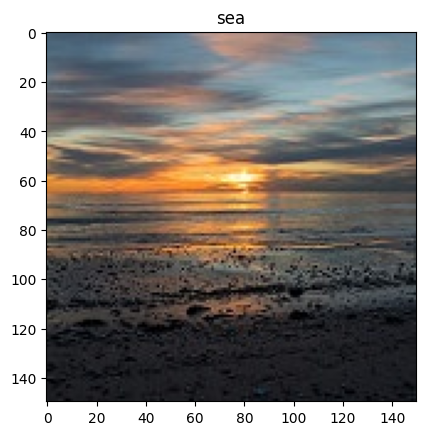

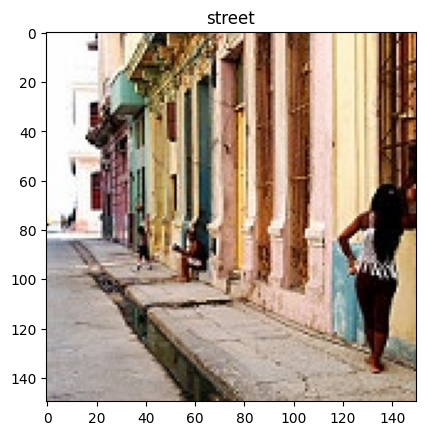

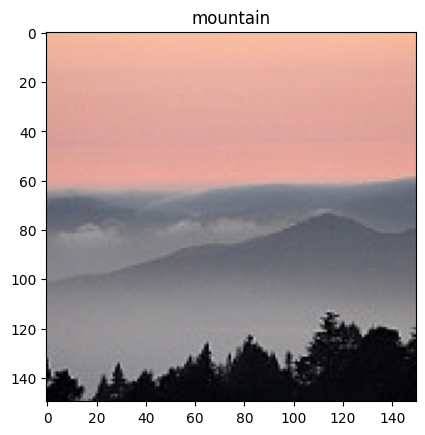

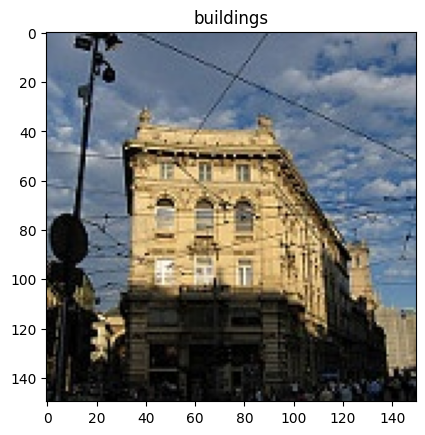

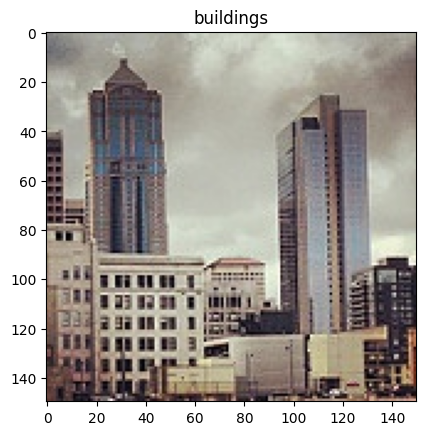

In [31]:
if torch.cuda.is_available():
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
outputs = model(images)
_, predictions = torch.max(outputs.data, 1)

# Plot some of the images with their predictions
for i in range(min(len(images), 15)):  # Show up to 8 images
    show_image(images.cpu().data[i], class_names[predictions[i].item()])
